In [4]:
from astropy.wcs import WCS
from astropy.io import fits

In [265]:
import numpy as np
from numpy import inf
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Colormap
import scipy
from scipy import io
import glob
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
import aplpy
import copy
import glob
import re

def collector(path):
    '''Collects all IDL save data from a given path and stores each file as an element in a list.'''

    filenames = glob.glob(path)

    data = {'data': [scipy.io.readsav(filenames[i], python_dict=True) for i in range(
        len(filenames))], 'filenames': filenames}
    return data


def separator(data):
    '''Compiles data into separate lists of extended and point sources'''

    point_data = [[data['data'][i]['source_array'][j] for j in range(len(
        data['data'][i]['source_array'])) if data['data'][i]['source_array'][j][-2] is None] for i in range(len(data['data']))]

    extended_data = [[data['data'][i]['source_array'][j] for j in range(len(
        data['data'][i]['source_array'])) if data['data'][i]['source_array'][j][-2] is not None] for i in range(len(data['data']))]

    return {'extsources': extended_data, 'psources': point_data}

def pixelate(RA_zoom, DEC_zoom, n_bins, RA_total, DEC_total, FLUX_total):
    import numpy as np
    #Check to see which dimension is larger so that a square in ra,DEC can 
    #be returned
    if (RA_zoom[1]-RA_zoom[0]) > (DEC_zoom[1]-DEC_zoom[0]):
        zoom = RA_zoom
    else:
        zoom = DEC_zoom

    #Find the size of the bins using the largest dimension and the num of bins
    binsize = (zoom[1]-zoom[0])/n_bins

    #Create arrays for ra and DEC that give the left side of each pixel
    
    RA_bin_array = (np.array(range(n_bins)) * binsize) + RA_zoom[0]
    DEC_bin_array = (np.array(range(n_bins)) * binsize) + DEC_zoom[0]
        
    #Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(RA_bin_array),len(DEC_bin_array)))

    #Histogram components into ra bins
    RA_histogram = np.digitize(RA_total,RA_bin_array)
    ###print RA_histogram

    #Begin for loop over both dimensions of pixels, starting with ra
    for bin_i in range(len(RA_bin_array) - 2):
        #Find the indices that fall into the current ra bin slice
        RA_inds = np.where(RA_histogram == bin_i)

        #Go to next for cycle if no indices fall into current ra bin slice
        if len(RA_inds[0]) == 0:
            continue

        #Histogram components that fall into the current ra bin slice by DEC
        DEC_histogram = np.digitize(DEC_total[RA_inds],DEC_bin_array)
        #Begin for loop by DEC over ra bin slice
        for bin_j in range(len(DEC_bin_array) -2):
            
            #Find the indicies that fall into the current DEC bin
            DEC_inds = np.where(DEC_histogram == bin_j)

            #Go to next for cycle if no indices fall into current DEC bin			
            if len(DEC_inds[0]) == 0:
                continue
            #Sum the FLUX components that fall into current ra/DEC bin
            pixels[bin_i,bin_j] = np.sum(FLUX_total[RA_inds[0][DEC_inds][0]])

    #Find the pixel centers in ra/DEC for plotting purposes
    RA_pixel_centers = (np.arange(n_bins) * binsize) + RA_zoom[0] + binsize/2.
    DEC_pixel_centers = (np.arange(n_bins) * binsize) + DEC_zoom[0] + binsize/2.

    return pixels, RA_pixel_centers, DEC_pixel_centers

def framer(RA,DEC):
    min_RA, max_RA, min_DEC, max_DEC = min(RA), max(RA), min(DEC), max(DEC)
    min_degrees = 50
    x = max_RA - min_RA
    y = max_DEC - min_DEC
    z = .25 * max(x,y)
    if (x > y) and (x - y > min_degrees/3600.):
        RA_zoom_min = min_RA - z
        RA_zoom_max = max_RA + z
        DEC_zoom_min = min_DEC - .5*(x-y) - z
        DEC_zoom_max = max_DEC + .5*(x-y) + z
    elif (y > x) and (y - x > min_degrees/3600.):
        RA_zoom_min = min_RA - .5*(y-x) - z
        RA_zoom_max = max_RA + .5*(y-x) + z
        DEC_zoom_min = min_DEC - z
        DEC_zoom_max = max_DEC + z
    else:
        RA_zoom_min = RA[0] - .1
        RA_zoom_max = RA[-1] + .1
        DEC_zoom_min = DEC[0] - .1
        DEC_zoom_max = DEC[-1] + .1
    return {'RA_zoom_min': RA_zoom_min, 'RA_zoom_max': RA_zoom_max,
            'DEC_zoom_min': DEC_zoom_min, 'DEC_zoom_max': DEC_zoom_max}

def all_seeker(data):
    
    separated = separator(data)
    
    
    indexed_point_sources_RA = [[separated['psources'][i][j]['RA']
                                 for j in range(len(separated['psources'][i]))]
                                for i in range(len(separated['psources']))]
    indexed_point_sources_DEC = [[separated['psources'][i][j]['DEC']
                                  for j in range(len(separated['psources'][i]))]
                                 for i in range(len(separated['psources']))]
    indexed_point_sources_FLUX = [[separated['psources'][i][j]['FLUX']['I'][0]
                                for j in range(len(separated['psources'][i]))]
                               for i in range(len(separated['psources']))]
    indexed_point_sources_XX = [[separated['psources'][i][j]['FLUX']['XX'][0]
                                 for j in range(len(separated['psources'][i]))]
                                for i in range(len(separated['psources']))]
    indexed_point_sources_YY = [[separated['psources'][i][j]['FLUX']['YY'][0]
                                 for j in range(len(separated['psources'][i]))]
                                for i in range(len(separated['psources']))]
    indexed_EO_sources_RA = [[[separated['extsources'][i][j]['EXTEND']['RA'][k]
                               for k in range(len(separated['extsources'][i][j]['EXTEND']['RA']))]
                              for j in range(len(separated['extsources'][i]))]
                             for i in range(len(separated['extsources']))]
    indexed_EO_sources_DEC = [[[separated['extsources'][i][j]['EXTEND']['DEC'][k]
                                for k in range(len(separated['extsources'][i][j]['EXTEND']['DEC']))]
                               for j in range(len(separated['extsources'][i]))]
                              for i in range(len(separated['extsources']))]
    indexed_EO_sources_FLUX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['I'][0]
                              for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                             for j in range(len(separated['extsources'][i]))]
                            for i in range(len(separated['extsources']))]
    indexed_EO_sources_XX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XX'][0]
                               for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                              for j in range(len(separated['extsources'][i]))]
                             for i in range(len(separated['extsources']))]
    indexed_EO_sources_YY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YY'][0]
                               for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                              for j in range(len(separated['extsources'][i]))]
                             for i in range(len(separated['extsources']))]

    for i in range(len(data['data'])):
        for j in range(len(indexed_EO_sources_RA[i])):
            for k in range(len(indexed_EO_sources_RA[i][j])):
                if indexed_EO_sources_RA[i][j][k] > 180:
                    indexed_EO_sources_RA[i][j][k] -= 360
        for j in range(len(indexed_point_sources_RA[i])):
            if indexed_point_sources_RA[i][j] > 180:
                indexed_point_sources_RA[i][j] -= 360

    all_RA = [[indexed_point_sources_RA[i][j]
               for j in range(len(indexed_point_sources_RA[i]))] + [indexed_EO_sources_RA[i][j][k]
              for j in range(len(indexed_EO_sources_RA[i]))
              for k in range(len(indexed_EO_sources_RA[i][j]))]
              for i in range(len(data['data']))]
    all_DEC = [[indexed_point_sources_DEC[i][j]
                for j in range(len(indexed_point_sources_DEC[i]))] + [indexed_EO_sources_DEC[i][j][k]
               for j in range(len(indexed_EO_sources_DEC[i]))
               for k in range(len(indexed_EO_sources_DEC[i][j]))]
               for i in range(len(data['data']))]
    all_FLUX = [[indexed_point_sources_FLUX[i][j]
              for j in range(len(indexed_point_sources_FLUX[i]))] + [indexed_EO_sources_FLUX[i][j][k]
             for j in range(len(indexed_EO_sources_FLUX[i]))
             for k in range(len(indexed_EO_sources_FLUX[i][j]))]
             for i in range(len(data['data']))]
    all_XX = [[indexed_point_sources_XX[i][j]
               for j in range(len(indexed_point_sources_XX[i]))] + [indexed_EO_sources_XX[i][j][k]
              for j in range(len(indexed_EO_sources_XX[i]))
              for k in range(len(indexed_EO_sources_XX[i][j]))]
              for i in range(len(data['data']))]
    all_YY = [[indexed_point_sources_YY[i][j]
               for j in range(len(indexed_point_sources_YY[i]))] + [indexed_EO_sources_YY[i][j][k]
              for j in range(len(indexed_EO_sources_YY[i]))
              for k in range(len(indexed_EO_sources_YY[i][j]))]
              for i in range(len(data['data']))]
    all_BEAM = [np.asarray(np.asarray(all_XX[i]) + np.asarray(all_YY[i])) /
                np.asarray(all_FLUX[i]) for i in range(len(data['data']))]
    
    return {'indexed_point_sources_RA': indexed_point_sources_RA, 'indexed_point_sources_DEC': indexed_point_sources_DEC,
            'indexed_point_sources_FLUX': indexed_point_sources_FLUX, 'indexed_point_sources_XX': indexed_point_sources_XX,
            'indexed_point_sources_YY': indexed_point_sources_YY, 'indexed_EO_sources_RA': indexed_EO_sources_RA,
            'indexed_EO_sources_DEC': indexed_EO_sources_DEC, 'indexed_EO_sources_FLUX': indexed_EO_sources_FLUX,
            'indexed_EO_sources_XX': indexed_EO_sources_XX, 'indexed_EO_sources_YY': indexed_EO_sources_YY,
            'all_RA': all_RA, 'all_DEC': all_DEC, 'all_FLUX': all_FLUX, 'all_XX': all_XX, 'all_YY': all_YY,
            'all_BEAM': all_BEAM}

def sidebyside(data,fits_file,minI=0,sumI=0,binwidth=2,sigmawidth=4,EOid=None):
    
    from astropy.wcs import WCS
    from astropy.io import fits
    from astropy import units as u
    
    '''
    
    This uses the previous functions to plot an EO from MWA data next to a plot of the EO from TGSS data,
    and a plot of the TGSS EO with overlaid with the contours of the MWA EO.
    
    '''
    
    separated = separator(data)

                #######################################################################
        
    sought = all_seeker(data)
    
    indexed_point_sources_RA = copy.deepcopy(sought['indexed_point_sources_RA'])
    indexed_point_sources_DEC = copy.deepcopy(sought['indexed_point_sources_DEC'])
    indexed_point_sources_FLUX = copy.deepcopy(sought['indexed_point_sources_FLUX'])
    indexed_point_sources_XX = copy.deepcopy(sought['indexed_point_sources_XX'])
    indexed_point_sources_YY = copy.deepcopy(sought['indexed_point_sources_YY'])
    indexed_EO_sources_RA = copy.deepcopy(sought['indexed_EO_sources_RA'])
    indexed_EO_sources_DEC = copy.deepcopy(sought['indexed_EO_sources_DEC'])
    indexed_EO_sources_FLUX = copy.deepcopy(sought['indexed_EO_sources_FLUX'])
    indexed_EO_sources_XX = copy.deepcopy(sought['indexed_EO_sources_XX'])
    indexed_EO_sources_YY = copy.deepcopy(sought['indexed_EO_sources_YY'])
    all_RA = copy.deepcopy(sought['all_RA'])
    all_DEC = copy.deepcopy(sought['all_DEC'])
    all_FLUX = copy.deepcopy(sought['all_FLUX'])
    all_XX = copy.deepcopy(sought['all_XX'])
    all_YY = copy.deepcopy(sought['all_YY'])
    all_BEAM = copy.deepcopy(sought['all_BEAM'])
    
    binwidth = binwidth * (1. / 3600.) # Converting binwidth in arcsec to degrees
    sigmawidth = sigmawidth * (1. / 3600.) # Converting binwidth in arcsec to degrees
    kernel = Gaussian2DKernel(stddev=(sigmawidth / binwidth))
    semi_zoom = 100. / 60.
    pixelreplacement = 1e-5
    cmap = matplotlib.cm.get_cmap('gist_heat')

    for i in range(len(data['data'])):
        if EOid is not None:
            sumI = 0
        
        for j in range(len(separated['extsources'][i])):

            if (EOid is not None) and (separated['extsources'][i][j]['ID'] != EOid):
                continue

            if (sum(indexed_EO_sources_FLUX[i][j]) > sumI) and ((max(indexed_EO_sources_XX[i][j]) != 0) and (max(indexed_EO_sources_YY[i][j]) != 0)):
                # ---------- Pixelating and convolving EO Plot
                EO_framed = framer(indexed_EO_sources_RA[i][j],indexed_EO_sources_DEC[i][j])
                EO_RA_zoom = [EO_framed['RA_zoom_min'],EO_framed['RA_zoom_max']]
                EO_DEC_zoom = [EO_framed['DEC_zoom_min'],EO_framed['DEC_zoom_max']]
                EO_RA_total = np.array(indexed_EO_sources_RA[i][j])
                EO_DEC_total = np.array(indexed_EO_sources_DEC[i][j])
                EO_FLUX_total = np.array(indexed_EO_sources_FLUX[i][j])
                EO_n_bins = int(max(EO_RA_zoom[1] - EO_RA_zoom[0],
                                    EO_DEC_zoom[1] - EO_DEC_zoom[0]) / binwidth)
                (EO_pixels, EO_RA_pixel_centers, EO_DEC_pixel_centers) = pixelate(
                    EO_RA_zoom, EO_DEC_zoom, EO_n_bins, EO_RA_total, EO_DEC_total, EO_FLUX_total)
                EO_pixels[EO_pixels == 0] = pixelreplacement
                EO_convolved = convolve(EO_pixels, kernel)

                #this is for MWA contours on TGSS graph
                
                w = WCS(fits_file)
                

                w = w.dropaxis(2)
                w = w.dropaxis(2)
                
                meshRA, meshDEC = np.meshgrid(EO_RA_pixel_centers,EO_DEC_pixel_centers)
                RA = meshRA.flatten()
                DEC = meshDEC.flatten()
                DATA = np.transpose(EO_convolved)
                contour_data = DATA.flatten()
                
                px, py = w.wcs_world2pix(RA,DEC,1)
                
                
                #this is for TGSS contours on MWA graph
                
                meshRA1, meshDEC1 = np.meshgrid(np.arange(269),np.arange(287))
                RA1 = meshRA1.flatten()
                DEC1 = meshDEC1.flatten()
                
                wx, wy = w.wcs_pix2world(RA1,DEC1,1)
                
        
                #print 'shape(px), shape(RA) shape(DEC) shape(DATA)',px.shape, RA.shape, DEC.shape, DATA.shape
                
                #these four variables are used to center the TGSS plot
                
                RA_center = (EO_RA_pixel_centers[-1] + EO_RA_pixel_centers[0]) / 2
                DEC_center = (EO_DEC_pixel_centers[-1] + EO_DEC_pixel_centers[0]) / 2
                RA_radius = abs((EO_RA_pixel_centers[-1] - EO_RA_pixel_centers[0]) / 2)
                DEC_radius = abs((EO_DEC_pixel_centers[-1] - EO_DEC_pixel_centers[0]) / 2)
                
        
        
                #######################################################################
                
                #Plotting!
                
                #main figure to plot on 
                fig = plt.figure(figsize=(20,20))
                
                fig.suptitle('EO Source {} from ObsID {}'.format\
                    (separated['extsources'][i][j]['ID'],\
                    [int(s) for s in re.findall('\d+',data['filenames'][i])][0],\
                    separated['extsources'][i][j]['FREQ']), fontsize = 30)
                
                #this figure is plot of EO w/ log-scale contours
                
                
                f1 = aplpy.FITSFigure(fits_file,figure=fig,)
                f1.show_colorscale(cmap='hot',vmin=0)   
                f1.show_grid()
                f1.add_colorbar()
                f1.remove_colorbar()
                
                f1.show_scalebar(1)
                f1.scalebar.set_length(2 * u.arcminute)
                f1.scalebar.set_corner(corner='bottom right')
                f1.scalebar.set_label("2 arcminutes")
                f1.scalebar.set_color('blue')
                f1.scalebar.set_frame(True)
                
                
                f1.set_title('TGSS EO Plot with MWA Contours (Scale bar = 2 arcminutes)')
                f1.set_xaxis_coord_type('scalar')
                f1.set_yaxis_coord_type('scalar')
                f1.tick_labels.set_xformat('%11.3f')
                f1.tick_labels.set_yformat('%11.3f')
               
                #f1.recenter(RA_center,DEC_center,RA_radius,DEC_radius) <-- if you want to recenter this
                
                ax = fig.gca()

                contours = ax.tricontour(px,py,contour_data,colors='b',norm=LogNorm())

                ax.patch.set_alpha(0.0)
                
                #plt.savefig('/home/champ8/uwchamp2017/tgss_mwa/1130788624/newcontours/EO'+'{}'.format(separated['extsources'][i][j]['ID'])+'tricontour.png', bbox_inches='tight')
   
    plt.show()
    return px, py, contour_data

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmax to  3.285e-01 [aplpy.core]


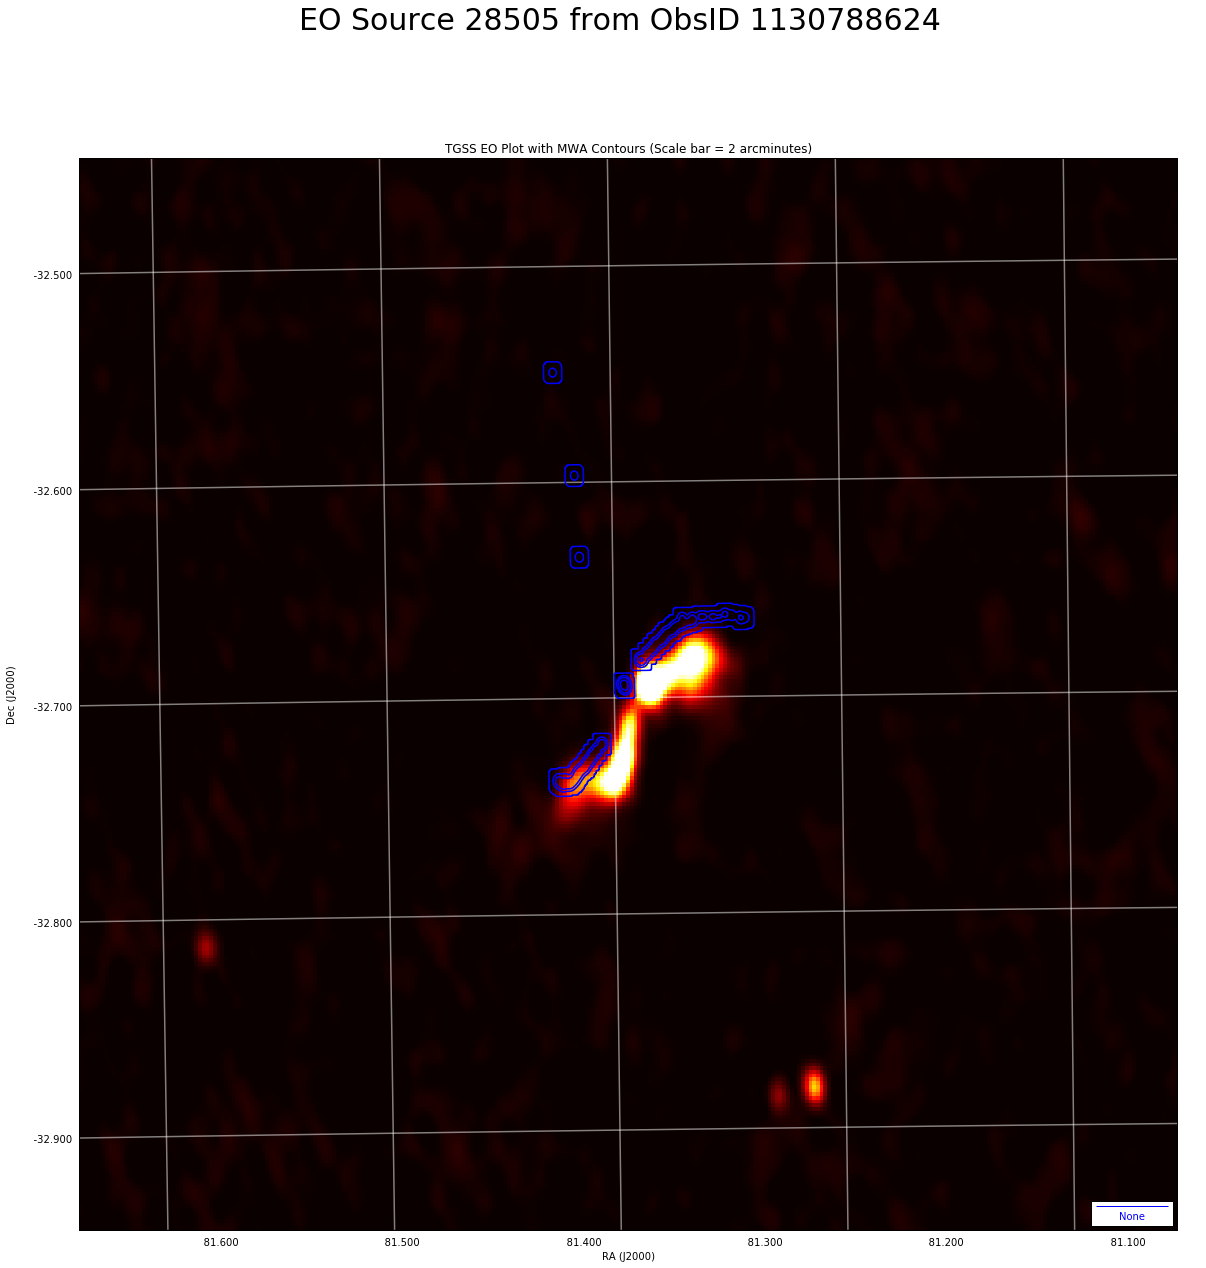

In [266]:
px, py, contour_data = sidebyside(data,'TGSSfits/624_28505.FITS',EOid=28505)

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmax to  3.285e-01 [aplpy.core]


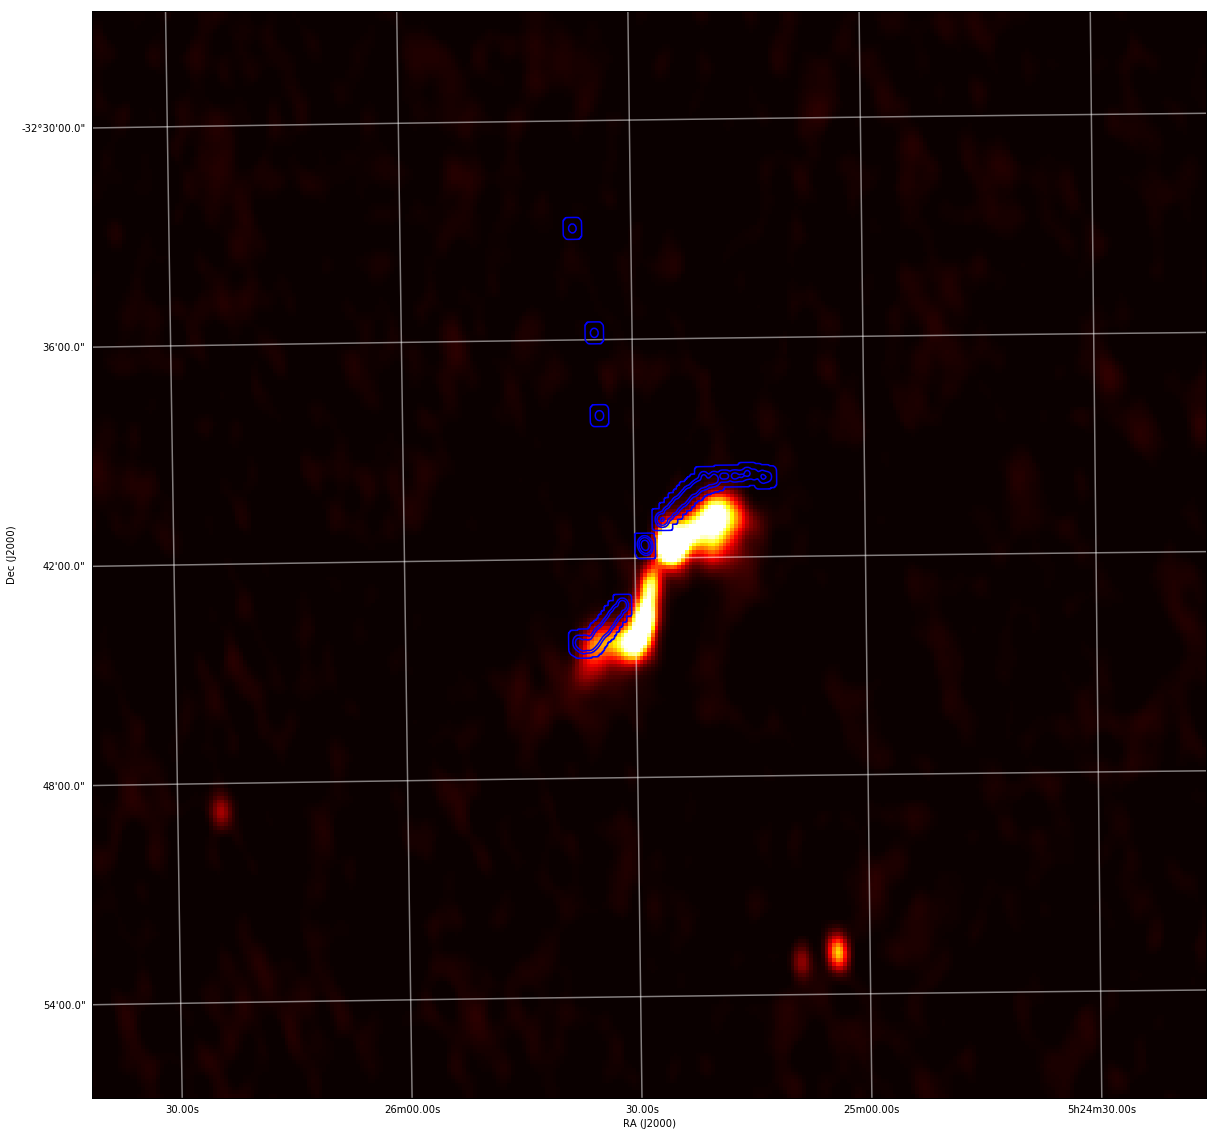

In [126]:

fig = plt.figure(figsize=(20,20))

f = aplpy.FITSFigure('624_TGSSfits/624_28505.FITS',figure=fig,)
f.show_colorscale(cmap='hot',vmin=0)   
f.show_grid()

ax = fig.gca()

contours = ax.tricontour(px,py,contour_data,colors='b',norm=LogNorm())



#ax.patch.set_alpha(0.0)


plt.show()

In [19]:
fits = fits.open('624_TGSSfits/624_28864.FITS')[0]
print fits.header

AttributeError: 'HDUList' object has no attribute 'open'

In [6]:
data = collector('new_source_arrays/1130788624_source_array.sav')
sep = separator(data)

In [252]:
eor0_data = collector('diffuse_survey_source_arrays/1131454296_source_array.sav')

In [264]:
data1 = collector('diffuse_survey_source_arrays/1130781304_source_array.sav')

In [ ]:
                '''
                this is the mess from the above code that i took out since im not using it
                
                EO_plot = ax1.imshow(np.transpose(EO_convolved), \
                    norm = LogNorm(vmin=pixelreplacement),\
                    origin = "lower", interpolation = "none", cmap = cmap,\
                    extent = [EO_RA_pixel_centers[0], EO_RA_pixel_centers[-1], \
                    EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1]] )
                
                contour_plot_1 = ax1.contour(np.transpose(EO_convolved), colors=('green'), vmin=0, alpha=.8, extent=[EO_RA_pixel_centers[0], EO_RA_pixel_centers[-1], \
                    EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1]],norm=LogNorm())
                
                ax1.grid()
                ax1.set_xlabel('RA')
                ax1.set_ylabel('DEC')
                ax1.minorticks_on()
                ax1.set_title('Plot of EO from MWA data')
                ax1.set_xlim(ax1.get_xlim()[::-1])
                ax1.set_xlim(EO_RA_pixel_centers[-1], EO_RA_pixel_centers[0])
                ax1.set_ylim(EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1])
    

                #second plot uses aplpy module to plot a FITS file of the EO from TGSS
                
                f = aplpy.FITSFigure(fits_file,figure=fig,subplot=[0.3,0.1,0.7,0.7])
                f.show_colorscale(cmap='hot',vmin=0)
                #f.show_contour(fits_file,layer='tgss',colors='g',norm=LogNorm())                
                
                f.add_grid()
                f.add_colorbar()
                f.ticks.show()
                f.set_nan_color('black')
                f.recenter(RA_center,DEC_center,RA_radius,DEC_radius)
                f.set_title('Plot of EO from TGSS')
                f.set_xaxis_coord_type('scalar')
                f.set_yaxis_coord_type('scalar')
                f.tick_labels.set_xformat('%11.3f')
                f.tick_labels.set_yformat('%11.3f')       
                
                #third plot is TGSS file with MWA contour
                ###
                f2 = aplpy.FITSFigure(fits_file,figure=fig,subplot=[0.6,0.1,0.7,0.7])
                f2.show_colorscale(cmap='hot',vmin=0),#aspect='equal')
                
                f2.add_grid()
                f2.add_colorbar()
                f2.set_nan_color('black')
                f2.recenter(RA_center,DEC_center,RA_radius,DEC_radius)
                f2.remove_colorbar()
                f2.set_title('TGSS EO Plot with MWA Contours')
                f2.set_xaxis_coord_type('scalar')
                f2.set_yaxis_coord_type('scalar')
                f2.tick_labels.set_xformat('%11.3f')
                f2.tick_labels.set_yformat('%11.3f')
                ###
               
                               
                #print 'contour_data.shape, px.shape, py.shape',contour_data.shape, px.shape, py.shape
                
                f1 = aplpy.FITSFigure(fits_file,figure=fig,subplot=[0.6,0.1,0.7,0.7])
                f1.show_colorscale(cmap='hot',vmin=0)   
                f1.show_grid()
                f1.add_colorbar()
                f1.remove_colorbar()
                f1.set_title('TGSS EO Plot with MWA Contours')
                f1.set_xaxis_coord_type('scalar')
                f1.set_yaxis_coord_type('scalar')
                f1.tick_labels.set_xformat('%11.3f')
                f1.tick_labels.set_yformat('%11.3f')
                f1.recenter(RA_center,DEC_center,RA_radius,DEC_radius)
                
                ax = fig.add_axes([0.6,0.1,0.7,0.7])

                contours = ax.tricontour(px,py,contour_data,colors='b',norm=LogNorm())
                
                ax.set_xlim(ax1.get_xlim()[::-1])
                ax.set_xlim(EO_RA_pixel_centers[-1], EO_RA_pixel_centers[0])
                ax.set_ylim(EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1])
                ax.set_aspect('equal')
                
                ax.patch.set_alpha(0.0)
                
                ###
                ax2 = fig.add_axes([0.7,0.1,0.4,0.4])
                #contour_plot_2 = ax2.contour(np.transpose(EO_convolved), colors=('green'), vmin=0, alpha=.8, extent=[EO_RA_pixel_centers[-1], EO_RA_pixel_centers[0], \
                 #   EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1]], norm = LogNorm() )
                   
                DATA = np.transpose(EO_convolved)
                contour_data = DATA.flatten()
                
                contours = ax.tricontour(px,py,contour_data,colors='b',norm=LogNorm())
                
                ax2.patch.set_alpha(0.0)
                
                
                hdu_list = fits.open(fits_file)
                image_data = hdu_list[0].data
                cont_data = image_data.flatten()
                
                ax = fig.gca()
                
                
                EO_plot = plt.imshow(np.transpose(EO_convolved), \
                    norm = LogNorm(vmin=pixelreplacement),\
                    origin = "lower", interpolation = "none", cmap = cmap,\
                    extent = [EO_RA_pixel_centers[0], EO_RA_pixel_centers[-1], \
                    EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1]] )
                
                DATA = np.transpose(EO_convolved)
                
                contours = ax.tricontour(wx,wy,cont_data,colors='b',norm=LogNorm())
                
                #print 'wx.shape, wy.shape, cont_data.shape',wx.shape, wy.shape, cont_data.shape
                
                #ax.patch.set_alpha(0.0)
                ###
                
                #ax2.set_aspect('equal')
                #ax2.patch.set_alpha(0.0)
                #ax2.set_xlim(ax2.get_xlim()[::-1])
                #ax2.set_xlim(EO_RA_pixel_centers[0], EO_RA_pixel_centers[-1])
                #ax2.set_ylim(EO_DEC_pixel_centers[0], EO_DEC_pixel_centers[-1])
                #ax2.minorticks_off()
                #ax2.axes.get_xaxis().set_visible(False)
                #ax2.axes.get_yaxis().set_visible(False)
                '''